In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import configargparse
from aspire.volume import Volume
from aspire.utils.rotation import Rotation as aspire_Rotation
from scipy.spatial.transform import Rotation as scipy_Rotation
import numpy as np
import os
import logging
import time

from cryomap_align.utils import init_config, try_mkdir
from cryomap_align.vol_utils import center_vol
from cryomap_align.gauss_opt_utils import run_gaussian_opt
from cryomap_align.opt_refinement import run_nelder_mead_refinement

/Data/Packages/Utilities/miniconda3/envs/optimization_env/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2023-12-16 03:46:46,391	INFO util.py:159 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.


2023-12-16 03:46:46,836 WARNING [MDAnalysis.coordinates.AMBER] netCDF4 is not available. Writing AMBER ncdf files will be slow.


/Data/Packages/Utilities/miniconda3/envs/optimization_env/lib/python3.11/site-packages/MDAnalysis/topology/TPRParser.py:161: DeprecationWarning: 'xdrlib' is deprecated and slated for removal in Python 3.13
  import xdrlib


I developed this module in a way that it would be easy for me to use in the future, so some of the functionalities it has are not useful for the project (like reading all my inputs from config files). For this reason I will have to do things in a non-optimal way below. This does not impact the method as it's just unimportant software stuff.

In [3]:
results_refine = np.load("results_with_refinement.npz")
results_noise = np.load("results_for_noise.npz")

In [14]:
def calc_error(mtx_stack1, mtx_stack2):
    cos_theta = (
        np.trace(
            np.matmul(mtx_stack1, mtx_stack2.transpose((0, 2, 1))), axis1=1, axis2=2
        )
        - 1
    ) / 2
    cos_theta[cos_theta > 1] = 1
    cos_theta[cos_theta < -1] = -1
    error = np.arccos(cos_theta) * (180) / np.pi

    return error

In [8]:
list(results_refine.keys())

['true_mtx',
 'optim_max_wemd',
 'refin_max_wemd',
 'optim_max_l2',
 'refin_max_l2',
 'run_time_wemd',
 'run_time_l2']

In [29]:
error_optim = []
error_refin = []
run_time_optim = []
run_time_refin = []

for i in range(1):  # results_refine["true_mtx"].shape[1]):
    true_mtx = results_refine["true_mtx"][0, i]
    optim_mtx_wemd = results_refine["optim_max_wemd"][0, i]
    refin_mtx_wemd = results_refine["refin_max_wemd"][0, i]
    optim_mtx_l2 = results_refine["optim_max_l2"][0, i]
    refin_mtx_l2 = results_refine["refin_max_l2"][0, i]

    error_optim.append(calc_error(true_mtx, optim_mtx_wemd))
    error_refin.append(calc_error(true_mtx, refin_mtx_wemd))
    error_optim.append(calc_error(true_mtx, optim_mtx_l2))
    error_refin.append(calc_error(true_mtx, refin_mtx_l2))

    run_time_optim.append("WEMD \n" + str(results_refine["run_time_wemd"][0, i, :, 0].mean().round(1)))
    run_time_optim.append("L2 \n" + str(results_refine["run_time_l2"][0, i, :, 0].mean().round(1)))
    run_time_refin.append("WEMD \n" + str(results_refine["run_time_wemd"][0, i, :, 1].mean().round(1)))
    run_time_refin.append("L2 \n" + str(results_refine["run_time_l2"][0, i, :, 1].mean().round(1)))

In [35]:
np.where(error_optim[0] > 90)

(array([ 7, 11, 15, 17, 19, 21, 29, 36, 41, 43]),)

In [79]:
run_time_optim

['22.2', '21.6']

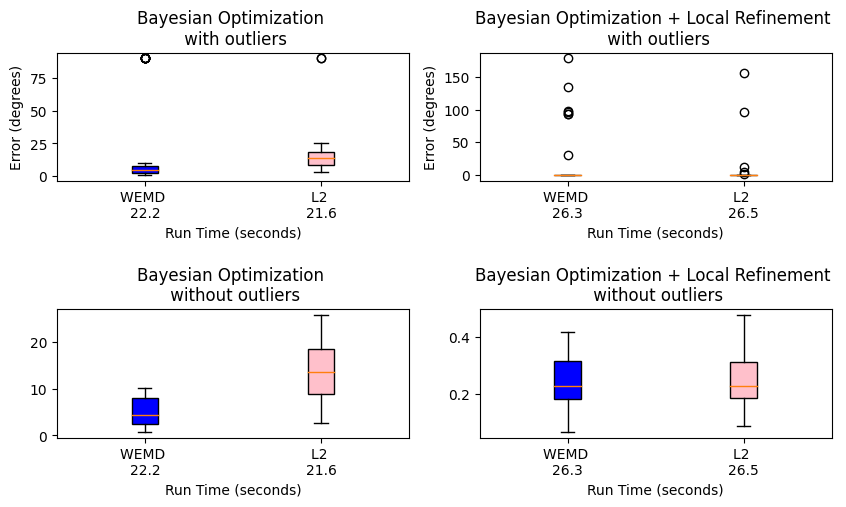

In [99]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(2, 2, figsize=(10, 5))

bplot_00 = ax[0, 0].boxplot(error_optim, patch_artist=True, labels=run_time_optim)

bplot_01 = ax[0, 1].boxplot(error_refin, patch_artist=True, labels=run_time_refin)

bplot_10 = ax[1, 0].boxplot(error_optim, patch_artist=True, showfliers=False, labels=run_time_optim)
bplot_11 = ax[1, 1].boxplot(error_refin, patch_artist=True, showfliers=False, labels=run_time_refin)


for bplot in (bplot_00, bplot_01, bplot_10, bplot_11):
    for patch, color in zip(bplot["boxes"], ["blue", "pink"]):
        patch.set_facecolor(color)

ax[0, 0].set_xlabel("Run Time (seconds)")
ax[0, 1].set_xlabel("Run Time (seconds)")
ax[1, 0].set_xlabel("Run Time (seconds)")
ax[1, 1].set_xlabel("Run Time (seconds)")

ax[0, 0].set_ylabel("Error (degrees)")
ax[0, 1].set_ylabel("Error (degrees)")

ax[0, 0].set_title("Bayesian Optimization \n with outliers")
ax[0, 1].set_title("Bayesian Optimization + Local Refinement \n with outliers")
ax[1, 0].set_title("Bayesian Optimization \n without outliers")
ax[1, 1].set_title("Bayesian Optimization + Local Refinement \n without outliers")


plt.subplots_adjust(hspace=1.0)

In [100]:
noise_error_snr1 = []
noise_error_snr2 = []
run_time_snr1 = []
run_time_snr2 = []

for i in range(results_noise["true_mtx"].shape[0]):
    for j in range(1):  # results_noise["true_mtx"].shape[1]):
        true_mtx = results_noise["true_mtx"][i, j]
        refin_mtx_wemd = results_noise["refin_mtx_wemd"][i, j]
        refin_mtx_l2 = results_noise["refin_mtx_l2"][i, j]

        if i == 0:
            noise_error_snr1.append(calc_error(true_mtx, refin_mtx_wemd))
            noise_error_snr1.append(calc_error(true_mtx, refin_mtx_l2))
            run_time_snr1.append("WEMD \n" + str(results_noise["run_time_wemd"][i, j, :, 1].mean().round(1)))
            run_time_snr1.append("L2 \n" + str(results_noise["run_time_l2"][i, j, :, 1].mean().round(1)))

        elif i == 1:
            noise_error_snr2.append(calc_error(true_mtx, refin_mtx_wemd))
            noise_error_snr2.append(calc_error(true_mtx, refin_mtx_l2))
            run_time_snr2.append("WEMD \n" + str(results_noise["run_time_wemd"][i, j, :, 1].mean().round(1)))
            run_time_snr2.append("L2 \n" + str(results_noise["run_time_l2"][i, j, :, 1].mean().round(1)))

In [84]:
list(results_noise.keys()), results

['true_mtx',
 'optim_mtx_wemd',
 'refin_mtx_wemd',
 'optim_mtx_l2',
 'refin_mtx_l2',
 'run_time_wemd',
 'run_time_l2']

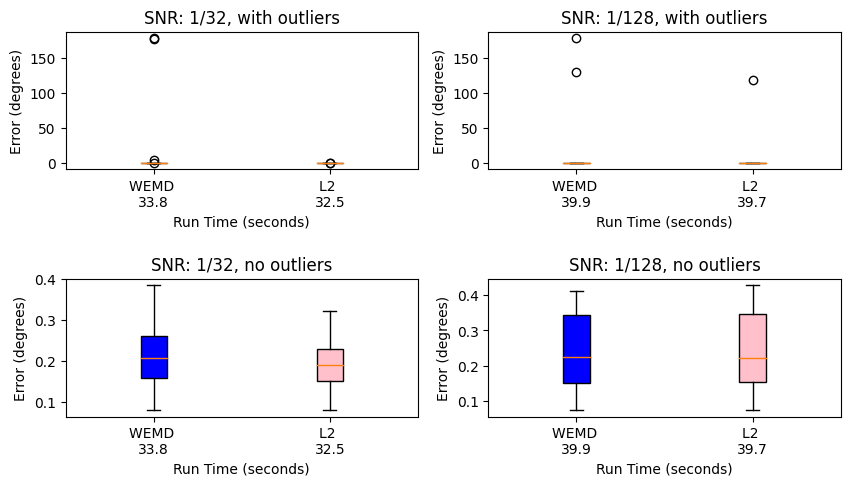

In [104]:
fig, ax = plt.subplots(2, 2, figsize=(10, 5))

bplot_00 = ax[0, 0].boxplot(noise_error_snr1, patch_artist=True, labels=run_time_snr1)
bplot_01 = ax[0, 1].boxplot(noise_error_snr2, patch_artist=True, labels=run_time_snr2)
bplot_10 = ax[1, 0].boxplot(noise_error_snr1, patch_artist=True, showfliers=False, labels=run_time_snr1)
bplot_11 = ax[1, 1].boxplot(noise_error_snr2, patch_artist=True, showfliers=False, labels=run_time_snr2)


for bplot in (bplot_00, bplot_01, bplot_10, bplot_11):
    for patch, color in zip(bplot["boxes"], ["blue", "pink"]):
        patch.set_facecolor(color)

ax[0, 0].set_xlabel("Run Time (seconds)")
ax[0, 1].set_xlabel("Run Time (seconds)")
ax[1, 0].set_xlabel("Run Time (seconds)")
ax[1, 1].set_xlabel("Run Time (seconds)")

ax[0, 0].set_ylabel("Error (degrees)")
ax[1, 0].set_ylabel("Error (degrees)")
ax[0, 0].set_title("SNR: 1/32, with outliers")
ax[1, 0].set_title("SNR: 1/32, no outliers")

ax[0, 1].set_ylabel("Error (degrees)")
ax[1, 1].set_ylabel("Error (degrees)")
ax[0, 1].set_title("SNR: 1/128, with outliers")
ax[1, 1].set_title("SNR: 1/128, no outliers")

# set spacing between vertical plots
plt.subplots_adjust(hspace=0.8)

In [11]:
true_mtx = results_refine["true_mtx"][0, 0, 43]
optim_mtx = results_refine["optim_max_wemd"][0, 0, 43]
refin_mtx = results_refine["refin_max_wemd"][0, 0, 43]

In [22]:
reflect = np.eye(3)
reflect[2, 2] = -1

calc_error(true_mtx[np.newaxis, ...], reflect @ optim_mtx[np.newaxis, ...])

array([5.28076861])

In [62]:
true_mtx, optim_mtx

(array([[ 0.3455638 , -0.73860651, -0.57883167],
        [-0.90520263, -0.09976554, -0.41310418],
        [ 0.24737397,  0.66671377, -0.70306391]]),
 array([[ 0.33441222, -0.69691247, -0.63441426],
        [-0.90000379, -0.03646333, -0.43435419],
        [-0.27957401, -0.7162286 ,  0.63941765]]))

In [10]:
vol0 = Volume.load("volumes/emd_3683.map.gz")

2023-12-16 03:36:45,000 INFO [aspire.volume.volume] volumes/emd_3683.map.gz with dtype float32 loaded as None


In [11]:
vol0.save("emd_3683_orig.mrc")

In [13]:
np.linalg.det(optim_mtx)

-0.9999999454839296

In [24]:
import sys

parser = configargparse.ArgumentParser()

parser.add_argument(
    "-c",
    "--config",
    is_config_file=True,
    help="Path to config file.",
    required=True,
)

init_config(parser)
config = parser.parse_args(sys.argv)

In [66]:
# rotate volume with true and refined
rot_true = aspire_Rotation.from_matrix(true_mtx.astype(np.float32))
rot_refin = aspire_Rotation.from_matrix(refin_mtx.astype(np.float32))
rot_optim = aspire_Rotation.from_matrix(optim_mtx.astype(np.float32))

vol0_rot_true = vol0.rotate(rot_true)
vol0_rot_refin = vol0.rotate(rot_refin)
vol0_rot_optim = vol0.rotate(rot_optim)

# save volumes
vol0_rot_true.save("emd_3683_true.map.gz")
vol0_rot_refin.save("emd_3683_refin.map.gz")
vol0_rot_optim.save("emd_3683_optim.map.gz")